# 1. Importing Libraries

In [1]:
import numpy as np
import math
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import tqdm.notebook as tq

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

import utils
import utils_cl

import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook
%load_ext autoreload

# 2. Anomaly Detection  Distance-based Clustering

## 2.1. Weekly consumpsion Extracting

> Tải dữ diệu gốc đã được chuẩn hóa về các mốc thời điểm đều nhau trong ngày (1 ngày gồm 4 mốc : 0h 6h 12h 18h).<br>
- Backfill dữ liệu Nan
- Gộp dữ liệu theo mã công tơ, mỗi samples là một Time Series trong 1 tuần tương ứng

In [2]:
full_df = pd.read_csv("dataset/normalized_data.csv")
full_df.columns = ['timestamp','import_kwh','meter_id','is_fraud','date','import_kwh_shift1','consumption']
full_df.drop(['import_kwh', 'import_kwh_shift1'], axis=1, inplace = True)

full_df['timestamp'] = pd.to_datetime(full_df.timestamp)
full_df['date'] = pd.to_datetime(full_df.date)
full_df.fillna(method='bfill', inplace = True)
full_df.set_index('date', inplace=True)

full_df['start_day'] = full_df.index.to_period('W').start_time
full_df = full_df[full_df['start_day'] != '2016-12-26']
full_df = full_df[full_df['start_day'] != '2018-03-26']

df = full_df.groupby(['meter_id', 'start_day'])['consumption'].apply(list)
df = pd.DataFrame(df)
df.reset_index(inplace = True)

>Drop các tuần không đủ `4*7 = 28` điểm dữ liệu

In [3]:
week_dropped = 0
for ind in tq.tqdm_notebook(range(df.shape[0])):
    len_list_consumption = len(list(df[df.index == ind ]['consumption'])[0])
    if len_list_consumption != 28 :
        df.drop(ind , inplace=True)
        week_dropped += 1
        
print("Number of lacked data week : ", week_dropped)


Number of lacked data week :  220


In [4]:
list_col = ['D' + str(i + 1) for i in range(28)]
df[list_col] = pd.DataFrame(df.consumption.tolist(), index= df.index)
df.drop('consumption', axis = 1, inplace = True)

>Danh sách các mã công tơ gian lận và thời điểm bị bắt gian lận trích trên báo cáo bên điện lực.

In [5]:
fraud_milestones = [('PP07000684209001','2017-12-29'),
 ('PP07000670259001','2017-01-03'),
 ('PP07000693227001','2017-08-14'),
 ('PP07000713473001','2017-04-12'),
 ('PP07000662970001','2017-03-02'),
 ('PP07000700839001','2017-05-23'),
 ('PP07000668984001','2017-08-24'),
 ('PP07000683751001','2017-10-25'),
 ('PP07000683750001','2017-10-25'),
 ('PP07000613734001','2017-03-24'),
 ('PP07000673219001','2017-04-24'),
 ('PP07000682085001','2017-10-27'),
 ('PP07000613618001','2017-11-29'),
 ('PP07000600208001','2017-10-05'),
 ('PP07000600209001','2017-10-05'),
 ('PP07000678169001','2017-07-06'),
 ('PP01000134773001','2017-12-12'),
 ('PP01000624985001','2017-12-28'),
 ('PP01000621525001','2017-01-11'),
 ('PP01000117448001','2017-04-14'),
 ('PP01000117849001','2017-10-25'),
 ('PP01000110500001','2017-03-27'),
 ("PP01000103859001","2017-10-30"),
 ('PP01000131431001','2017-04-03'),
 ("PP01000103454001",'2017-08-03'),
 ('PP01000101145001','2017-03-06'),
 ('PP01000140094001','2017-01-09'),
 ('PP01000101975001','2017-02-07'),
 ('PP03000810040001','2017-08-12'),
 ('PP03000832565001','2017-06-13'),
 ('PP03000806717001','2017-07-12'),
 ('PP03000902373001','2017-07-17'),
 ('PP03000809863001','2017-12-19'),
 ('PP03000882852001','2017-12-21'),
 ('PP03000902981001','2017-04-21'),
 ('PP03000804097001','2017-06-24'),
 ('PP03000805922001','2017-09-25'),
 ('PP03000804137001','2017-10-30'),
 ('PP03000904351001','2017-03-28'),
 ('PP03000898466001','2017-06-29'),
 ('PP05000989390001','2017-05-02'),
 ('PP05000948327001','2017-08-10'),
 ('PP05000977900001','2017-01-13'),
 ('PP05000501075001','2017-01-13'),
 ('PP05000501411001','2017-10-13'),
 ('PP05000524904001','2017-04-13'),
 ('PP05000951373001','2017-04-14'),
 ('PP05000967512001','2017-03-15'),
 ('PP05000960339001','2017-03-15'),
 ('PP05000515674001','2017-04-18'),
 ('PP05000967753001','2017-07-20'),
 ('PP05000944240001','2017-05-22'),
 ('PP05000504291001','2017-04-21'),
 ('PP05000968892001','2017-05-22'),
 ('PP05000961578001','2017-05-22'),
 ('PP05000953931001','2017-11-23'),
 ('PP05000502843001','2017-02-24'),
 ('PP05000941329001','2017-11-25'),
 ('PP05000509756001','2017-08-30'),
 ('PP05000524362001','2017-01-04'),
 ('PP05000516894001','2017-04-05'),
 ('PP05000522325001',"2017-12-06"),
 ('PP05000517007001','2017-08-07'),
 ('PP05000515078001','2017-03-09'),
 ('PP05000991348001','2017-05-09'),
 ('PP09000810551001','2017-08-11'),
 ('PP09000884920001','2017-04-11'),
 ('PP09000802199001','2017-09-11'),
 ('PP09000811262001','2017-02-13'),
 ('PP09000120555001','2017-04-17'),
 ('PP09000890287001','2017-02-20'),
 ('PP09000808752001','2017-12-21'),
 ('PP09000817228001','2017-10-24'),
 ('PP09000907245001','2017-11-24'),
 ('PP09000821975001','2017-10-28'),
 ('PP09000837585001','2017-11-28'),
 ('PP09000808816001','2017-12-28'),
 ('PP09000808816001','2017-04-29'),
 ('PP09000892588001','2017-10-31'),
 ('PP09000894390001','2017-10-31'),
 ("PP09000894706001","2017-12-08") 
]

> Gán nhãn gian lận `is_fraud = True` cho các tuần của công tơ tại thời điểm trước bị bị bắt gian lận

In [6]:
df['is_fraud'] = False
for _pair in tq.tqdm_notebook(fraud_milestones):
    mdd = _pair[0]
    str_date = _pair[1]
    df['is_fraud'].loc[(df['meter_id'] == mdd) &
                                (df['start_day'] < pd.Timestamp(str_date).to_period('W').start_time)] = True

> Loại bỏ những samples có dữ liệu quá bất thường (tồn tại điểm dữ liệu quá lớn hoặc bị âm quá thấp) 
, tránh gây ảnh hưởng đến kết quả phân cụm

In [7]:
df['isnot_keep'] = df.iloc[:, 2:-1].apply(lambda row: max(row) > 50 or min(row) < -50, axis = 1)
df = df[df['isnot_keep'] == False]
df.drop('isnot_keep', axis=1, inplace=True)
df.reset_index(drop = True)

,meter_id,start_day,D1,D2,D3,D4,D5,D6,D7,D8,...,D20,D21,D22,D23,D24,D25,D26,D27,D28,is_fraud
0,PP01000100340001,2017-01-02,1.071990,1.071990,0.950588,1.272025,0.521183,0.521183,1.371933,1.025683,...,0.952474,0.503377,0.503377,0.632368,0.632368,0.428766,0.428766,1.130079,0.787332,False
1,PP01000100340001,2017-01-09,0.763673,0.763673,0.763673,0.763673,0.763673,0.763673,1.522158,0.876736,...,0.880946,0.597618,0.597618,0.867206,2.178154,1.050095,1.050095,0.223318,0.762987,False
2,PP01000100340001,2017-01-16,0.506998,0.506998,0.897201,0.767088,0.728221,0.728221,0.813047,0.746418,...,0.955296,0.599409,0.599409,0.888135,1.177667,0.640047,0.640047,1.571213,0.766795,False
3,PP01000100340001,2017-01-23,0.675018,0.675018,1.109636,1.117002,0.570628,0.570628,1.406446,0.836815,...,0.534937,0.986200,0.986200,1.002349,1.075476,0.967791,0.967791,1.493868,0.626669,False
4,PP01000100340001,2017-01-30,0.811750,0.811750,0.903721,1.238893,0.768862,0.768862,3.122375,1.813596,...,0.782079,0.618889,0.618889,1.766039,1.025119,0.935988,0.935988,1.405387,1.235285,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66273,PP09000917354001,2018-02-19,0.615746,0.761565,0.594556,0.616500,0.622205,0.741239,0.689988,0.714554,...,0.661808,0.781470,0.855940,0.692604,0.608086,0.651967,1.529247,1.177936,1.384933,False
66274,PP09000917354001,2018-02-26,1.407403,1.170292,2.423855,2.120285,1.782779,0.944600,1.906704,1.886607,...,4.504948,2.905477,0.822343,3.013649,2.192781,1.543887,1.942385,1.942385,1.942385,False
66275,PP09000917354001,2018-03-05,1.942385,1.942385,1.942385,1.942385,1.942385,1.942385,1.942385,1.942385,...,2.272497,2.262339,0.727216,1.571482,1.803436,2.092781,0.328282,0.569763,1.039458,False
66276,PP09000917354001,2018-03-12,0.464563,1.390987,3.291773,2.549874,5.651065,-1.477639,2.220849,2.564015,...,2.041855,3.010341,3.493759,5.116455,4.148944,4.105020,0.357505,0.882543,0.680439,False


> Một số mô tả thống kê về dữ liệu

In [8]:
df.describe()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28
count,66278.000000,66278.000000,66278.000000,66278.000000,66278.000000,66278.000000,66278.000000,66278.000000,66278.000000,66278.000000,...,66278.000000,66278.000000,66278.000000,66278.000000,66278.000000,66278.000000,66278.000000,66278.000000,66278.000000,66278.000000
mean,2.394254,1.765952,1.858361,2.044905,2.473936,1.769276,1.878272,2.048578,2.497837,1.768827,...,1.855323,2.008153,2.465770,1.736959,1.870388,2.071933,2.385390,1.747410,1.866133,2.124754
std,2.832725,2.439864,2.569751,2.775115,2.849296,2.429386,2.638691,2.777040,2.867759,2.427837,...,2.617733,2.710494,2.856401,2.415176,2.436574,2.692178,2.842256,2.451337,2.360620,2.678429
min,-3.435601,-3.060491,-13.771810,-7.300050,-10.270559,-4.718928,-24.482123,-6.519607,-5.463640,-6.256746,...,-23.904212,-5.929678,-5.568473,-5.011948,-15.088394,-5.199777,-11.189315,-4.937839,-5.628115,-2.580211
25%,0.977671,0.633808,0.697558,0.765363,1.036179,0.630526,0.697675,0.765586,1.044102,0.632240,...,0.689835,0.747309,1.036222,0.616737,0.713140,0.777711,0.981172,0.619495,0.730691,0.808451
50%,1.732421,1.187688,1.263815,1.392247,1.803390,1.190292,1.273393,1.388988,1.811326,1.186126,...,1.249864,1.361038,1.807816,1.163668,1.300490,1.424327,1.739966,1.168741,1.337989,1.493380
75%,2.888897,2.033995,2.151024,2.364708,2.996462,2.046328,2.166510,2.354954,3.024328,2.048525,...,2.131445,2.312239,2.977061,2.010518,2.192357,2.444436,2.876205,2.005343,2.205784,2.527608
max,48.370748,48.002205,49.755054,47.339021,44.416405,44.024659,49.429260,48.154542,43.884160,46.391824,...,49.881547,44.710851,48.447961,43.270782,41.658808,46.254876,48.354857,49.080616,40.891896,45.624947


In [9]:
df.is_fraud.value_counts()

False    64718
True      1560
Name: is_fraud, dtype: int64

## 2.2. Clustering

> Trích tập luyện, chuẩn hóa dữ liệu về zscore theo từng features

In [64]:
X_train = df.iloc[:, 2:-1]
Y = df.iloc[:, -1].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

> Thực hiện phân cụm, với thuật toán : KMeans - Euclidean - 5 clusters (elbow method) <br>


In [65]:
from sklearn.cluster import KMeans

distance_used = utils_cl.distance_ED
cluster_number  = 5
n_iters = 500

km = KMeans(
    n_clusters = cluster_number, init = 'random',
    max_iter=n_iters, tol=1e-08, random_state=0
)

y_km = km.fit_predict(X_scaled)
centroids = km.cluster_centers_

In [66]:
# Elbow plotting
n_cluster = range(1, 10)
kmeans = [KMeans(n_clusters=i).fit(X_scaled) for i in n_cluster]
scores = [kmeans[i].score(X_scaled) for i in range(len(kmeans))]
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

<IPython.core.display.Javascript object>

> Có thể thấy đường elbow k tăng đáng kể từ khi số cụm `cluster_number = 5`, suy ra nếu tăng nhiều cụm thì cũng cho thêm lượng thông tin về sự khác biệt (variance) của các cụm trong thuật KMeans

In [67]:
count_cluster = [0]*cluster_number
count_fraud = [0]*cluster_number
for i, j in enumerate(y_km):
    count_cluster[j] += 1
    if Y[i] == True :
        count_fraud[j] += 1
        
print("Kết quả phân cụm (actual frauds / cluster members) :")
for j in range(cluster_number):
    print("Cluster {0} : {1} / {2}".format(j + 1, count_fraud[j], count_cluster[j] ))

Kết quả phân cụm (actual frauds / cluster members) :
Cluster 1 : 155 / 7428
Cluster 2 : 465 / 23973
Cluster 3 : 0 / 689
Cluster 4 : 37 / 1352
Cluster 5 : 903 / 32836


> `dict_DC` lưu khoảng cách của các members tới center của từng cluster 

In [68]:
dict_DC = {}
for i in range(cluster_number):
    dict_DC[i+1] = []
    
for i, j in enumerate(y_km):
    dict_DC[j+1].append(distance_used(centroids[j], X_train.iloc[i, :].values))

In [69]:
def distribution_plotting(cluster_number, is_print_individual = False):
    if cluster_number > 7:
        colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), cluster_number, replace = True)
    else :
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    if is_print_individual : 
        for i in range(cluster_number):
            plt.figure(figsize = (4, 2), dpi = 120)
            sns.distplot(dict_DC[i+1])
            plt.title("Distribution of Distance to Center"  + str(i+1))
        
    plt.figure(figsize = (6, 3), dpi = 120)
    for i in range(cluster_number):
        sns.kdeplot(dict_DC[i+1], label="cluster" + str(i+1), color = colors[i])
    plt.legend();
    plt.title("Distribution of Distance to center in Training set")
distribution_plotting(cluster_number, False)

<IPython.core.display.Javascript object>

## 2.3. Fraudly Meter Prediction 

**Aproach 1 :**
> Dựa trên ý tưởng : <br>
 - Các samples (theo tuần) là bất thường khi : xét trong một cụm, nó tập trung ở margin của cụm, tức là khoảng cách đến reprentatives của cụm (lấy là tâm cụm theo Kmeans) lớn hơn hẳn các điểm khác.
 - Với mỗi cụm, định nghĩa một *fraud threshold* . Dựa trên `dict_DC` với *X* là biến khoảng đến tâm trong mỗi cụm, *fraud threshold x* lấy theo quantile : $Pr[X < x] ≤ p$.
 - Chọn ngưỡng quantile p là : `percentile = 0.98`, ta có `quantile_radius` tương ứng với mỗi cụm.

In [70]:
average_radius = []
for j in range(cluster_number):
    average_radius.append(sum(dict_DC[j+1])/len(dict_DC[j+1]))
max_radius = []
for j in range(cluster_number):
    max_radius.append(max(dict_DC[j+1]))
quantile_radius = []
percentile = 0.98
for j in range(cluster_number):
    quantile_radius.append(pd.DataFrame(dict_DC[j+1]).quantile(percentile, axis = 0)[0])
print("average_radius :",  average_radius)
print("max_radius :",  max_radius)
print("quantile_radius :",  quantile_radius)

average_radius : [19.998804643374587, 12.02250694204606, 72.5453823381922, 40.17235867038965, 7.270980401758994]
max_radius : [58.24653534214036, 34.63753720513126, 176.6766528878646, 112.63588418078953, 22.849262342596322]
quantile_radius : [32.17772331098953, 18.227138515603087, 133.7896674680848, 85.53941490843852, 10.976147027007022]


In [71]:
def test_fraud_cluster(X_sample, cluster_belong, radius_cent, thresh_KM):
    dist2cent = distance_used(X_sample, centroids[cluster_belong - 1])
    is_fraud = (dist2cent > radius_cent[cluster_belong-1] * thresh_KM)
    return is_fraud

def prediction_result(test_set, radius_cent, thresh_KM = 1.0):
    N = test_set.shape[0]
    mdd_fraud_1week = []
    Y_predict = []
    ind_fraud_predicted = []
    count_fraud_predicted = [0]*cluster_number
    for i in tq.tqdm_notebook(range(N)):
        X_sample = test_set.iloc[i, :].values
        cluster_belong = y_km[i] + 1
        test_result = test_fraud_cluster(X_sample, cluster_belong, radius_cent, thresh_KM)
        if test_result == True :
            count_fraud_predicted[cluster_belong-1] += 1
            mdd_fraud_1week.append(df.iloc[i, 0])
            ind_fraud_predicted.append(i)
        Y_predict.append(test_result)
    return list(set(mdd_fraud_1week)), Y_predict, ind_fraud_predicted, count_fraud_predicted

> Các *weekly samples* có khoảng cách tới tâm lớn hơn `fraud threshold * thresh_KM` được cho là bất thường.<br>
> Biến `thresh_KM` để hiệu chỉnh, thể hiện cho lượng *weekly samples* bất thường có trong cụm, điều chỉnh `thresh_KM` hoặc `percentile`, để điều chỉnh số lượng bất thường được dự đoán.

In [72]:
test_set = X_train
radius_cent = quantile_radius
thresh_KM = 1

mdd_fraud_1week, Y_predict, ind_fraud_predicted, count_fraud_predicted = prediction_result(test_set, radius_cent, thresh_KM)

>**Dự đoán công tơ bất thường:**<br>
>Một công tơ dự đoán là bất thường nếu có số tuần liên tiếp (weekly samples) `consecutive_week` bị dự đoán là bất thường

In [73]:
list_mdd = df.meter_id.unique()
list_fraud = [i[0] for i in fraud_milestones if i[0] in list_mdd]

def predict_1(Y_pred, consecutive_week = 2):
    Y_predict = Y_pred
    test_df = pd.DataFrame()
    test_df['meter_id'] = df.meter_id
    test_df['pred'] = Y_predict
    test_df = test_df.groupby(['meter_id'])['pred'].apply(list)

    def test_consecutive_week(l):
        n = len(l)
        for i in range(n) :
            if l[i] == True:
                if sum(l[i : i+consecutive_week]) == consecutive_week:
                    return True
            else :
                continue
        return False
    mdd_fraud_n_week = []
    for i in range(test_df.shape[0]):
        l = test_df[i]
        if test_consecutive_week(l):
            mdd_fraud_n_week.append(test_df.index[i])

    n_fraud = len(set(mdd_fraud_n_week) & set(list_fraud))
    print("Consecutive_week : ", consecutive_week)
    print("Percentile of Fraud predicted: ", n_fraud/len(list_fraud))
    print("Percentile of Normal predicted: ", (len(mdd_fraud_n_week) - n_fraud)/1000)


> Nếu lấy `consecutive_week = 2`, có kết quả

In [74]:
predict_1(Y_predict, 2)

Consecutive_week :  2
Percentile of Fraud predicted:  0.3283582089552239
Percentile of Normal predicted:  0.094


> Nếu lấy `consecutive_week = 3`, có kết quả

In [75]:
predict_1(Y_predict, 3)

Consecutive_week :  3
Percentile of Fraud predicted:  0.208955223880597
Percentile of Normal predicted:  0.033


**Aproach 2 :** <br>
> - Dựa trên ý tưởng : Thay vì xét trong từng cụm và đánh giả khoảng cách của mỗi *weekly samples* tới tâm tương ứng để phát hiện bất thường, ta xét chung trong tất cả các cụm.
> - Khoảng cách của *weekly samples* đến tâm được lưu trong `total_dist`. `Fraud_fraction = 0.095`, là tỉ lệ lượng bất thường dự đoán.

In [76]:
total_dist = []
for i, j in enumerate(y_km):
    total_dist.append(distance_used(centroids[j], X_train.iloc[i, :].values))
    
fraud_fraction = 0.095
number_of_abnormal = int(fraud_fraction*len(total_dist))
thres_1 = pd.Series(total_dist).nlargest(number_of_abnormal).min()

N = X_scaled.shape[0]
Y_predict2 = [False]*N
for i in range(N):
    if total_dist[i] >= thres_1:
        Y_predict2[i] = True
        
predict_1(Y_predict2, 1)

Consecutive_week :  1
Percentile of Fraud predicted:  0.5970149253731343
Percentile of Normal predicted:  0.304


> Nếu lấy `consecutive_week = 2`, có tỉ lệ để đánh kết quả :

In [77]:
predict_1(Y_predict2, 2)

Consecutive_week :  2
Percentile of Fraud predicted:  0.417910447761194
Percentile of Normal predicted:  0.249


# 3. Anomaly Detection  Feature-based Clustering

## 3.1. Monthly consumpsion Extracting


> Để thực hiện trích các features, cần samples là các Time Series có độ dài lớn hơn, các *monthly samples* tương tự tự trích theo tháng. Các tiền xử lý đều tương tự như mục trước.

In [10]:
full_df['start_month'] = full_df.index.to_period('M').start_time

df2 = full_df.groupby(['meter_id', 'start_month'])['consumption'].apply(list)
df2 = pd.DataFrame(df2)
df2.reset_index(inplace = True)

from tqdm import tqdm
month_dropped = 0
for ind in tq.tqdm_notebook(range(df2.shape[0])):
    len_list_consumption = len(list(df2[df2.index == ind ]['consumption'])[0])
    if len_list_consumption > 4*31 or len_list_consumption < 4*28 :
        df2.drop(ind , inplace=True)
        month_dropped += 1
print("Number of dropped month : ")
print(month_dropped)


Number of dropped month : 
1220


In [11]:
df2['is_fraud'] = False
for _pair in tq.tqdm_notebook(fraud_milestones):
    mdd = _pair[0]
    str_date = _pair[1]
    df2['is_fraud'].loc[(df2['meter_id'] == mdd) &
                                (df2['start_month'] < pd.Timestamp(str_date).to_period('M').start_time)] = True

In [12]:
df2['isnot_keep'] = df2.iloc[:, 2].apply(lambda row: max(row) > 50 or min(row) < -50)
df2 = df2[df2['isnot_keep'] == False]
df2.drop('isnot_keep', axis=1, inplace=True)
df2.reset_index(drop = True)

,meter_id,start_month,consumption,is_fraud
0,PP01000100340001,2017-01-01,"[1.0719898562762542, 1.0719898562762546, 0.950...",False
1,PP01000100340001,2017-02-01,"[0.895121195127615, 0.8951211951275866, 1.2803...",False
2,PP01000100340001,2017-03-01,"[0.6571686778031562, 0.6571686778030994, 1.963...",False
3,PP01000100340001,2017-04-01,"[0.6166059082339075, 0.6166059082337938, 1.086...",False
4,PP01000100340001,2017-05-01,"[1.0685942492012828, 0.3721889763779132, 1.310...",False
...,...,...,...,...
14416,PP09000917354001,2017-10-01,"[-0.0716460025652168, 0.05414903846144625, -0....",False
14417,PP09000917354001,2017-11-01,"[2.868048680169068, 1.025119959177573, 3.97953...",False
14418,PP09000917354001,2017-12-01,"[3.120299114212912, 0.08464456180763591, 2.995...",False
14419,PP09000917354001,2018-01-01,"[1.282498163665423, 0.6079780079403463, 3.0473...",False


In [13]:
df2.is_fraud.value_counts()

False    14092
True       329
Name: is_fraud, dtype: int64

## 3.2. Features Generalization

> - Trích ra một số đặc trưng có thể đánh giá bất thường dựa trên *consumption*. Các features tự lựa chọn dựa theo [Hyndman et al. (2015)] (https://researchportal.bath.ac.uk/en/publications/forecast-forecasting-functions-for-time-series-and-linear-models).
> - Một số đặc trưng được chọn là : **mean** (Mean), **var** (Variance), **acf1** (First order of autocorrelation), **trend** (Strength of trend), **season** (Strength of season), **zero_counts** (Counting of zeros)**

In [82]:
cols = ['meter_id', 'start_month', 'mean', 'var', 'acf1', 'trend', 'season', 'zero_counts', 'is_fraud']

In [14]:
ts = np.array(df2.iloc[0, 2])

In [15]:
ts

array([1.07198986, 1.07198986, 0.95058757, 1.27202451, 0.52118313,
       0.52118313, 1.37193291, 1.02568286, 0.50894605, 0.50894605,
       0.92460941, 0.7509796 , 0.65382819, 0.65382819, 0.72042241,
       0.50079159, 0.57966265, 0.57966265, 1.05108687, 0.9524738 ,
       0.5033766 , 0.5033766 , 0.63236794, 0.63236794, 0.42876589,
       0.42876589, 1.13007864, 0.78733165, 0.76367259, 0.76367259,
       0.76367259, 0.76367259, 0.76367259, 0.76367259, 1.52215834,
       0.87673613, 0.6277623 , 0.6277623 , 0.88454888, 0.87345881,
       0.56443468, 0.56443468, 1.26127371, 0.72985277, 0.63420132,
       0.63420132, 0.89877303, 0.88094557, 0.59761767, 0.59761767,
       0.86720606, 2.17815386, 1.05009536, 1.05009536, 0.22331818,
       0.76298664, 0.50699822, 0.50699822, 0.89720138, 0.76708765,
       0.72822133, 0.72822133, 0.81304734, 0.74641837, 0.68579233,
       0.68579233, 1.63040417, 0.86453495, 0.65872481, 0.65872481,
       0.90154007, 0.83259241, 0.59858989, 0.59858989, 1.05932

In [19]:
import numpy as np

def ortho_poly_fit(x, degree = 1):
    n = degree + 1
    x = np.asarray(x).flatten()
    if(degree >= len(np.unique(x))):
            stop("'degree' must be less than number of unique points")
    xbar = np.mean(x)
    x = x - xbar
    X = np.fliplr(np.vander(x, n))
    q,r = np.linalg.qr(X)

    z = np.diag(np.diag(r))
    raw = np.dot(q, z)

    norm2 = np.sum(raw**2, axis=0)
    alpha = (np.sum((raw**2)*np.reshape(x,(-1,1)), axis=0)/norm2 + xbar)[:degree]
    Z = raw / np.sqrt(norm2)
    return Z, norm2, alpha


def ortho_poly_predict(x, alpha, norm2, degree = 1):
    x = np.asarray(x).flatten()
    n = degree + 1
    Z = np.empty((len(x), n))
    Z[:,0] = 1
    if degree > 0:
        Z[:, 1] = x - alpha[0]
    if degree > 1:
      for i in np.arange(1,degree):
          Z[:, i+1] = (x - alpha[i]) * Z[:, i] - (norm2[i] / norm2[i-1]) * Z[:, i-1]
    Z /= np.sqrt(norm2)
    return Z

In [55]:
Z, norm2_i, alpha_i = ortho_poly_fit(ts, degree = 1)
ts_reg = ortho_poly_predict(ts, alpha_i, norm2_i, degree = 1)

In [60]:
ts_reg

array([[ 0.09128709,  0.05201305],
       [ 0.09128709,  0.05201305],
       [ 0.09128709,  0.02242047],
       [ 0.09128709,  0.10077277],
       [ 0.09128709, -0.0822496 ],
       [ 0.09128709, -0.0822496 ],
       [ 0.09128709,  0.12512607],
       [ 0.09128709,  0.04072542],
       [ 0.09128709, -0.08523246],
       [ 0.09128709, -0.08523246],
       [ 0.09128709,  0.01608812],
       [ 0.09128709, -0.02623525],
       [ 0.09128709, -0.04991652],
       [ 0.09128709, -0.04991652],
       [ 0.09128709, -0.03368376],
       [ 0.09128709, -0.08722017],
       [ 0.09128709, -0.06799484],
       [ 0.09128709, -0.06799484],
       [ 0.09128709,  0.04691781],
       [ 0.09128709,  0.02288024],
       [ 0.09128709, -0.08659005],
       [ 0.09128709, -0.08659005],
       [ 0.09128709, -0.05514759],
       [ 0.09128709, -0.05514759],
       [ 0.09128709, -0.10477689],
       [ 0.09128709, -0.10477689],
       [ 0.09128709,  0.06617256],
       [ 0.09128709, -0.0173742 ],
       [ 0.09128709,

<IPython.core.display.Javascript object>


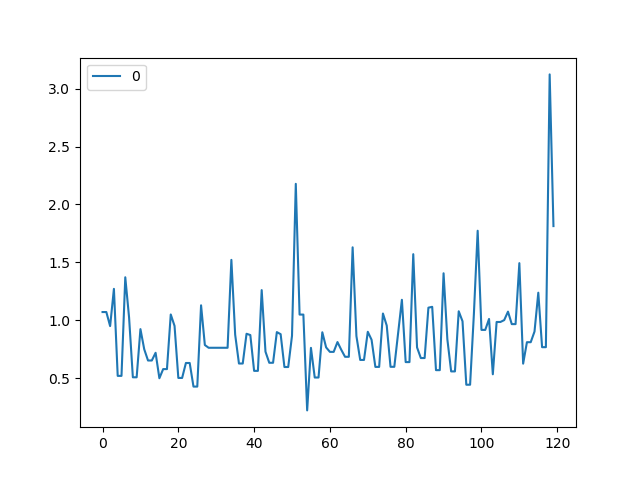

<IPython.core.display.Javascript object>


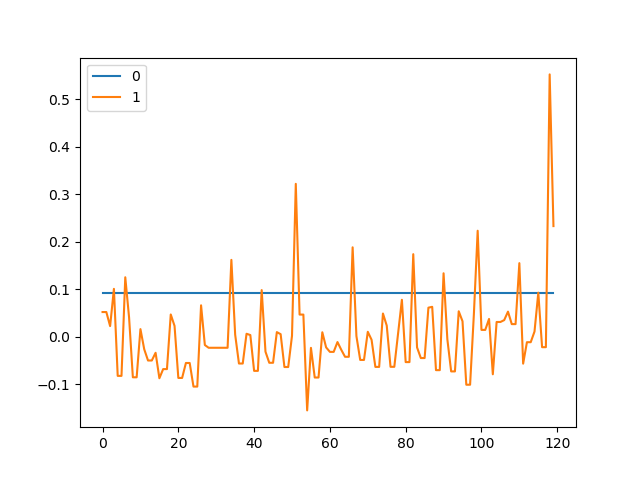

In [56]:
pd.DataFrame(ts).plot()
pd.DataFrame(ts_reg).plot()

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

def feature_extraction(ts):

    mean_ts = sum(ts) / len(ts)
    var_ts = sum((i - mean_ts) ** 2 for i in ts) / len(ts)
    acf1_ts = pd.Series(ts.astype(float)).autocorr(lag=1)
    
    ts_1 = pd.DataFrame()
    ts_1['time'] = full_df.timestamp[:len(ts)]
    ts_1['cs'] = ts
    ts_1.set_index("time", inplace = True)
    result_add = seasonal_decompose(ts_1['cs'], model = 'additive', extrapolate_trend='freq')
    residual =  result_add.resid
    trend = result_add.trend
    seasonal = result_add.seasonal
    
    try :
        trend_ts = max(0, 1 - np.var(residual)/np.var(residual + trend))
    except ZeroDivisionError:
        trend_ts = 0
    try :
        seasonal_ts = max(0, 1 - np.var(residual)/np.var(residual + seasonal))
    except ZeroDivisionError :
        seasonal_ts = 0
    
    zc_ts = sum(ts == 0)
    
    return [mean_ts, var_ts, acf1_ts, trend_ts, seasonal_ts, zc_ts]

In [ ]:
df3 = pd.DataFrame(columns=cols)
for i in tq.tqdm_notebook(range(df2.shape[0])):
    ts = np.array(df2.iloc[i, 2])
    list_feautures = feature_extraction(ts)
    df3.loc[i] = [df2.iloc[i, 0], df2.iloc[i, 1]] + list_feautures + [df2.iloc[i, -1]]

> Sau khi loại bỏ các điểm dữ liệu `Nan`, ta có thống kê mô tả về tập dữ liệu sau khi trích đặc trưng như sau :

In [ ]:
df3 = df3.dropna()
df3.reset_index(drop = True)

In [ ]:
df3.describe()

In [ ]:
df3.is_fraud.value_counts()

## 3.3. Density-Clustering and Fraudly Meter Prediction

> Trích tập luyện, chuẩn hóa dữ liệu về zscore theo từng features

In [ ]:
X_train2 = df3.iloc[:, 2:-1]
Y2 = df3.iloc[:, -1].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train2)
#X_scaled = X_train2

> Thực hiện phân cụm theo **TT DBSCAN**, đồng thời phát hiện các *monthly samples* là bất thường. <br>
**Phát hiện bất thường:**
<img src="img/dbscan_ilu0.png" alt="Drawing" style="width: 400px;"/>

> - Hai thông số *epsilon* `eps = 0.7` và *minimum samples* `min_samples = 5`. <br>
> - Trong đó : *epsilon* đặc tả cho cự li khi xét mật độ, *minimum samples* để chỉ mật độ tối thiểu để tạo cụm.<br>
> - Sau khi thuật toán DBSCAN thực thi, có kết quả phân cụm, đồng thời phát hiện được các điểm không thuộc cụm nào, gọi là *Noise*. Ta coi các điểm này là bất thường, tương ứng với xung quanh trong phạm vi *epsilon* không tồn tại hàng xóm nào.

In [ ]:
# Clustering
from sklearn.cluster import DBSCAN
# DBSCAN
eps = 0.7
min_samples = 5
labels_1 = utils_cl._DBSCAN(X_scaled, eps, min_samples)

> Kết quả phân cụm, nhãn `labels_1[i] = -1` ứng với điểm thứ `i` là bất thường

In [ ]:
from collections import Counter
Counter(labels_1)

In [ ]:
Y_predict_fb = []
mdd_fraud_1month = []
for i, j in enumerate(labels_1):
    if j == -1:
        Y_predict_fb.append(True)
        mdd_fraud_1month.append(df3.iloc[i, 0])
    else :
        Y_predict_fb.append(False)
mdd_fraud_1month = list(set(mdd_fraud_1month))

In [ ]:
print("Total fraudly predicted meters (monthly) : ")
len(mdd_fraud_1month)

> Ta có tỉ lệ đánh giá kết quả :

In [ ]:
list_mdd = set(df3.meter_id.unique())
list_fraud = set([i[0] for i in fraud_milestones if i[0] in list_mdd])
list_normal = list_mdd.difference(list_fraud)
n_fraud = len(set(mdd_fraud_1month) & set(list_fraud))
print("Percentile of Fraud predicted: ", n_fraud/len(list_fraud))
print("Percentile of Normal predicted: ", (len(mdd_fraud_1month) - n_fraud)/1000)

> Confusion matrix :

In [ ]:
mdd_normal_1month = list_mdd.difference(mdd_fraud_1month)
tp = len(set(mdd_fraud_1month) & set(list_fraud))
fp = len(list_fraud) - len(set(mdd_fraud_1month) & set(list_fraud))
tn = len(set(mdd_normal_1month) & set(list_normal))
fn = len(list_normal) - len(set(mdd_normal_1month) & set(list_normal))
print("[[{0}, {1}],\n [{2}, {3}]]".format(tp, fp, fn, tn))